In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=6acee406a235e5bfab64ad6d8fb62adb59f82612065b1a0e72455c0ccf5c1c50
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Start a SparkSession
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Yelp Analysis") \
    .getOrCreate()

In [ ]:


# Path to your JSON file in Google Drive
file_path = '/content/drive/MyDrive/yelp_dataset/yelp_academic_dataset_business.json'

# Read JSON file into a DataFrame using PySpark
df = spark.read.json(file_path)

# Display the DataFrame schema
df.printSchema()

# Display the first few rows of the DataFrame
df.show(5)

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [ ]:
# Total number of different cities
total_cities = df.select('city').distinct().count()
print("Total number of different cities:", total_cities)

# Total number of different states
total_states = df.select('state').distinct().count()
print("Total number of different states:", total_states)

# Total number of different postal codes
total_postal_codes = df.select('postal_code').distinct().count()
print("Total number of different postal codes:", total_postal_codes)

# Total number of different categories
total_categories = df.select('categories').distinct().count()
print("Total number of different categories:", total_categories)


Total number of different cities: 1416
Total number of different states: 27
Total number of different postal codes: 3362
Total number of different categories: 83161


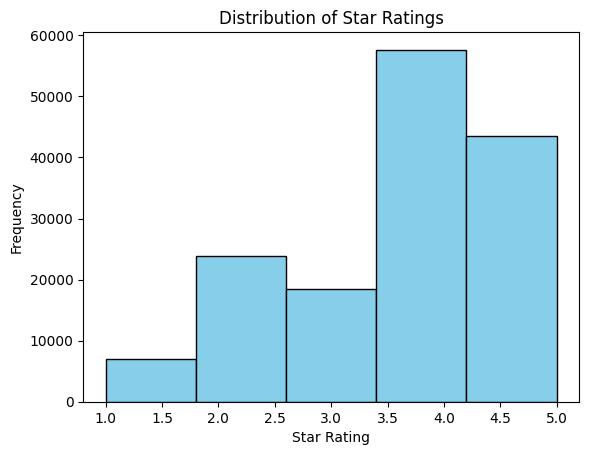

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

stars_pd = df.select('stars').toPandas()

# Distribution of Stars
plt.hist(stars_pd['stars'], bins=5, color='skyblue', edgecolor='black')
plt.xlabel('Star Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Star Ratings')
plt.show()



In [ ]:
df_pd = df.toPandas()


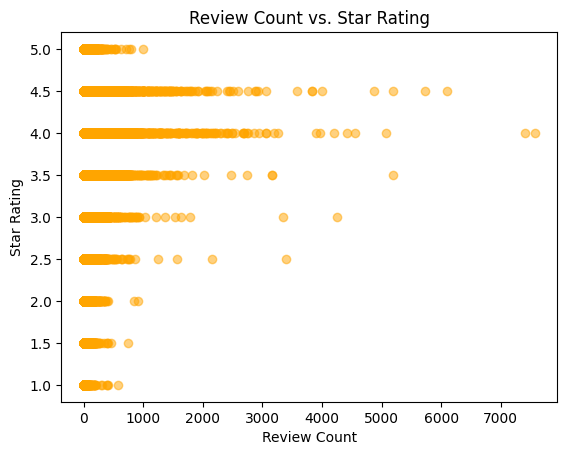

In [ ]:
# Review Count vs. Stars
plt.scatter(df_pd['review_count'], df_pd['stars'], color='orange', alpha=0.5)
plt.xlabel('Review Count')
plt.ylabel('Star Rating')
plt.title('Review Count vs. Star Rating')
plt.show()

<ipython-input-23-4e1db324f5ac>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pd['stars'], color='blue', shade=True)


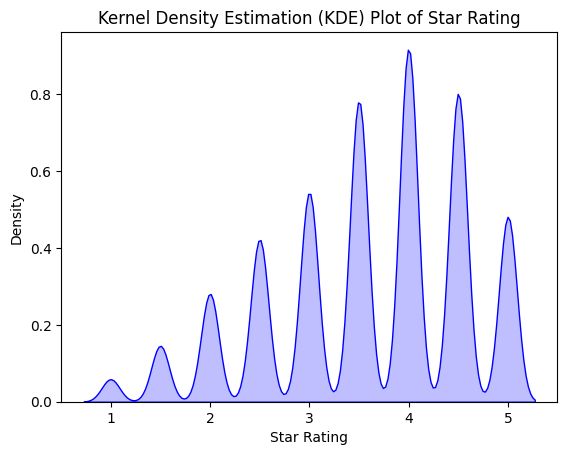

In [ ]:
import seaborn as sns

# Create a KDE plot for Star Rating
sns.kdeplot(df_pd['stars'], color='blue', shade=True)
plt.xlabel('Star Rating')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Star Rating')
plt.show()


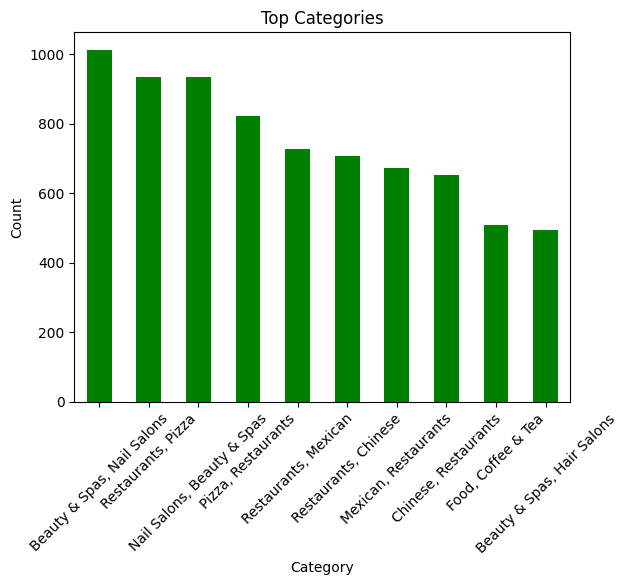

In [ ]:
# Top Categories
top_categories = df_pd['categories'].value_counts().nlargest(10)
top_categories.plot(kind='bar', color='green')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Top Categories')
plt.xticks(rotation=45)
plt.show()

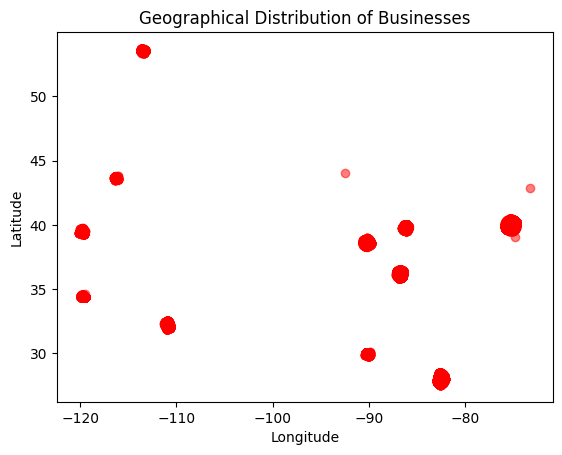

In [ ]:
# Geographical Distribution
plt.scatter(df_pd['longitude'], df_pd['latitude'], color='red', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Distribution of Businesses')
plt.show()

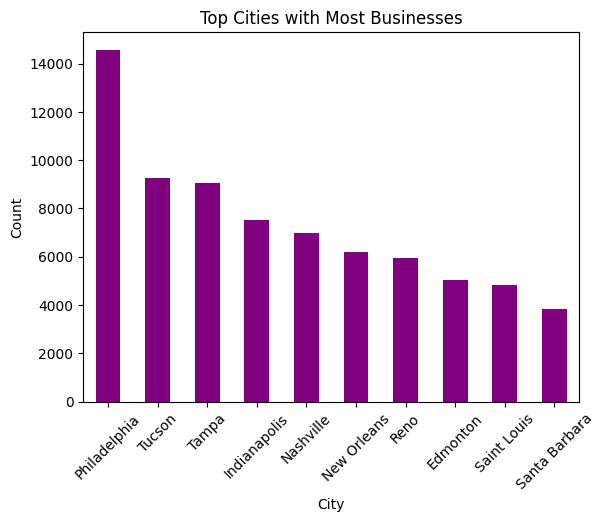

In [ ]:
city_counts = df_pd['city'].value_counts().nlargest(10)
city_counts.plot(kind='bar', color='purple')
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Top Cities with Most Businesses')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from pyspark.sql.functions import avg, count

# Group by city and count the number of businesses in each city
city_business_count = df.groupBy('city').agg(count('business_id').alias('business_count'))

# Filter cities with at least 50 businesses
city_business_count_filtered = city_business_count.filter(city_business_count['business_count'] >= 50)

# Join the filtered city business count back to the original DataFrame
filtered_df = df.join(city_business_count_filtered, 'city')

# Group by city and calculate the average star rating
city_avg_stars = filtered_df.groupBy('city').agg(avg('stars').alias('avg_stars'))

# Order by average star rating in descending order
city_avg_stars = city_avg_stars.orderBy('avg_stars', ascending=False)

# Show the top cities with the highest average star rating
print("Top cities with the highest average star rating (with at least 50 businesses):")
city_avg_stars.show(10)


Top cities with the highest average star rating (with at least 50 businesses):
+----------------+------------------+
|            city|         avg_stars|
+----------------+------------------+
|       Montecito| 4.155913978494624|
|   Safety Harbor| 4.129496402877698|
|   Santa Barbara|  4.05144946461217|
|Saint Pete Beach| 4.026315789473684|
|     Carpinteria| 4.016778523489933|
|        Gulfport|               4.0|
|    Lambertville|3.9838709677419355|
|  Webster Groves| 3.936936936936937|
|       Tampa Bay|3.9361702127659575|
|    Collingswood|  3.92603550295858|
+----------------+------------------+
only showing top 10 rows



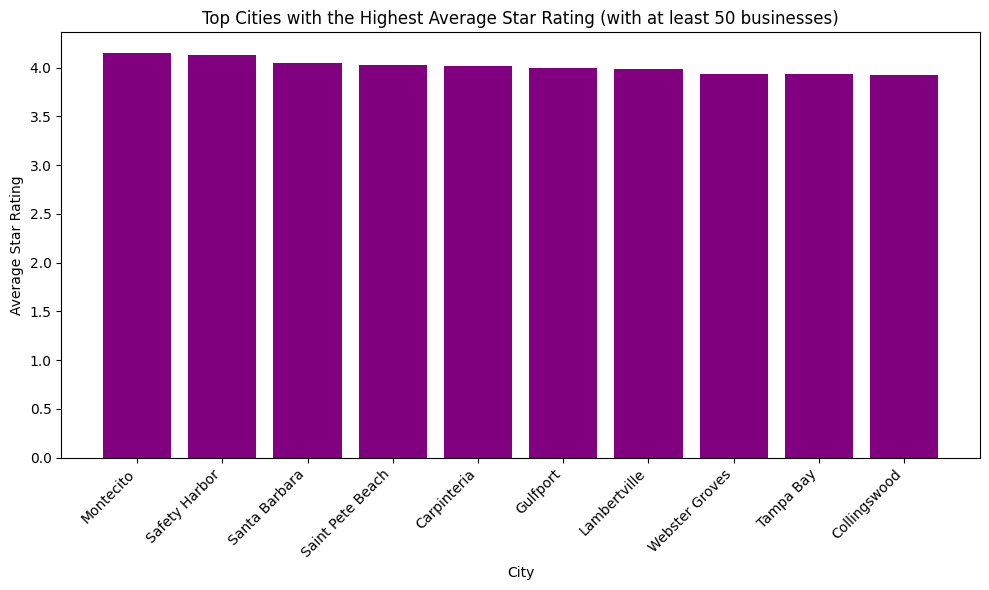

In [ ]:
import matplotlib.pyplot as plt

# Convert the result DataFrame to Pandas for plotting
city_avg_stars_pd = city_avg_stars.limit(10).toPandas()

# Plot the top cities with the highest average star rating
plt.figure(figsize=(10, 6))
plt.bar(city_avg_stars_pd['city'], city_avg_stars_pd['avg_stars'], color='purple')
plt.xlabel('City')
plt.ylabel('Average Star Rating')
plt.title('Top Cities with the Highest Average Star Rating (with at least 50 businesses)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


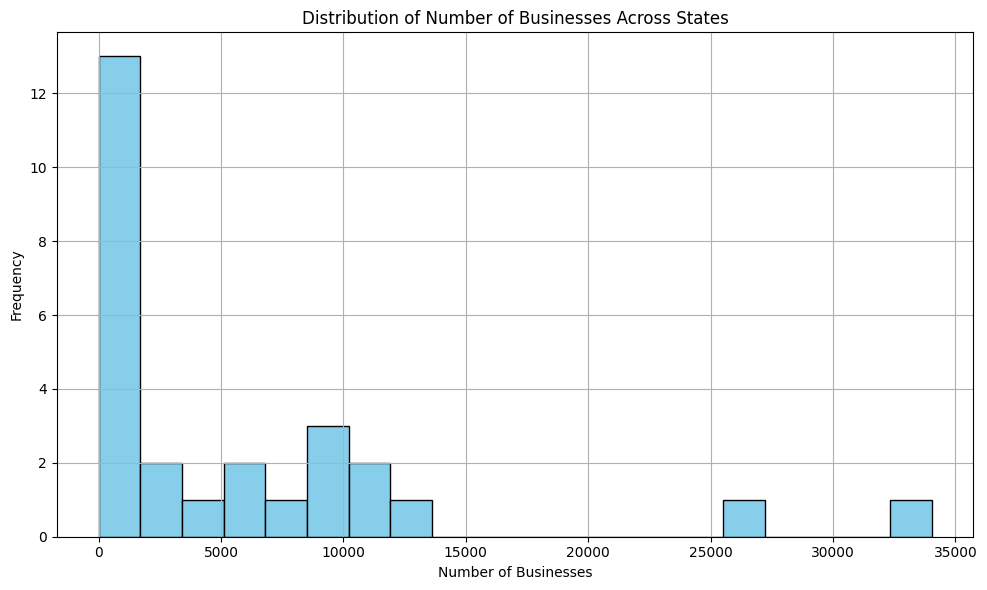

In [ ]:
import matplotlib.pyplot as plt
state_business_count = df.groupBy('state').agg(count('business_id').alias('business_count'))

# Convert the result DataFrame to Pandas for plotting
state_business_count_pd = state_business_count.toPandas()

# Plot the histogram of the number of businesses across states
plt.figure(figsize=(10, 6))
plt.hist(state_business_count_pd['business_count'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Businesses')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Businesses Across States')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql.functions import count

# Group by state and count the number of businesses in each state
state_business_count = df.groupBy('state').agg(count('business_id').alias('business_count'))

# Order by business count in descending order
state_business_count = state_business_count.orderBy('business_count', ascending=False)

# Show the top states with the most businesses
print("Top states with the most businesses:")
state_business_count.show(10)


Top states with the most businesses:
+-----+--------------+
|state|business_count|
+-----+--------------+
|   PA|         34039|
|   FL|         26330|
|   TN|         12056|
|   IN|         11247|
|   MO|         10913|
|   LA|          9924|
|   AZ|          9912|
|   NJ|          8536|
|   NV|          7715|
|   AB|          5573|
+-----+--------------+
only showing top 10 rows



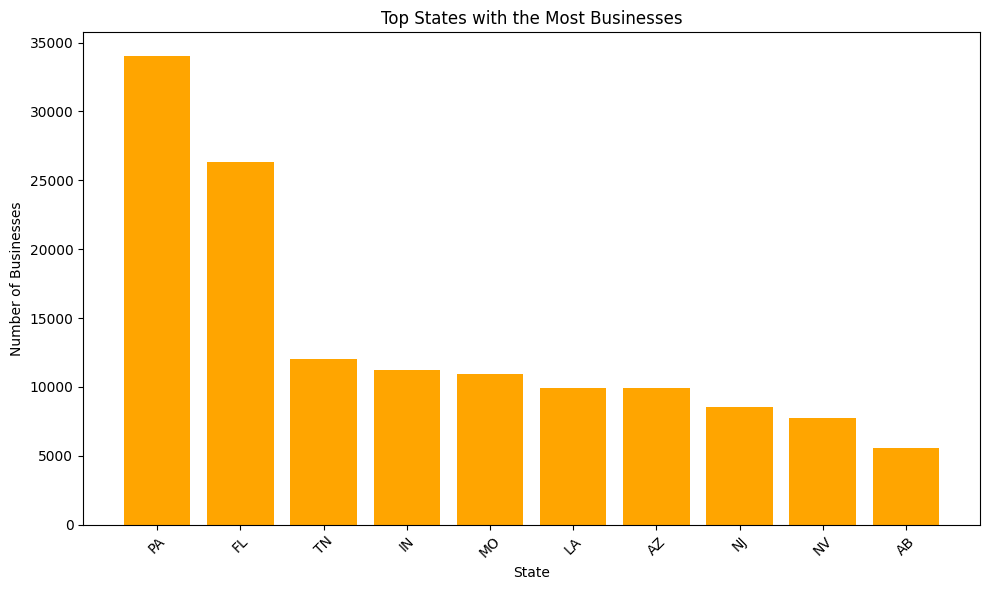

In [ ]:
import matplotlib.pyplot as plt

# Define the color for the bar plot (shade of orange)
bar_color = '#FFA500'  # Hex code for orange

# Convert the result DataFrame to Pandas for plotting
state_business_count_pd = state_business_count.limit(10).toPandas()

# Plot the top states with the most businesses
plt.figure(figsize=(10, 6))
plt.bar(state_business_count_pd['state'], state_business_count_pd['business_count'], color=bar_color)
plt.xlabel('State')
plt.ylabel('Number of Businesses')
plt.title('Top States with the Most Businesses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


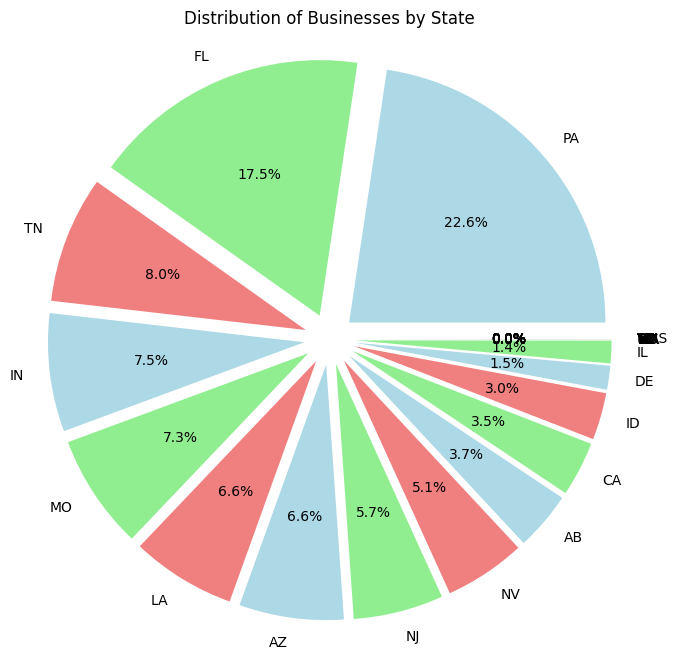

In [ ]:
import matplotlib.pyplot as plt
df_pd = df.toPandas()

# Get the state counts
state_counts = df_pd['state'].value_counts()

# Define colors for the pie chart
colors = ['lightblue', 'lightgreen', 'lightcoral']

# Create the pie chart
plt.figure(figsize=(8, 8))
explode = [0.1] * len(state_counts)  # Add explosion effect for 3D look
plt.pie(state_counts, labels=state_counts.index, autopct='%1.1f%%', colors=colors, explode=explode)

# Add a title
plt.title('Distribution of Businesses by State')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Show the plot
plt.show()


In [ ]:
from pyspark.sql.functions import avg, count

# Group by state and count the number of businesses in each state
state_business_count = df.groupBy('state').agg(count('business_id').alias('business_count'))

# Filter states with at least 50 businesses
state_business_count_filtered = state_business_count.filter(state_business_count['business_count'] >= 50)

# Join the filtered state business count back to the original DataFrame
filtered_df = df.join(state_business_count_filtered, 'state')

# Group by state and calculate the average star rating
state_avg_stars = filtered_df.groupBy('state').agg(avg('stars').alias('avg_stars'))

# Order by average star rating in descending order
state_avg_stars = state_avg_stars.orderBy('avg_stars', ascending=False)

# Show the top states with the highest average star rating
print("Top states with the highest average star rating (with at least 50 businesses):")
state_avg_stars.show(10)


Top states with the highest average star rating (with at least 50 businesses):
+-----+------------------+
|state|         avg_stars|
+-----+------------------+
|   CA|3.9967326542379396|
|   NV|3.7368762151652626|
|   ID|3.7076337586747257|
|   LA| 3.679161628375655|
|   FL|3.6109570831750855|
|   AZ|3.5920096852300243|
|   IN|3.5882457544234017|
|   PA|3.5730191838773173|
|   TN| 3.571499668214997|
|   MO| 3.546091817098873|
+-----+------------------+
only showing top 10 rows



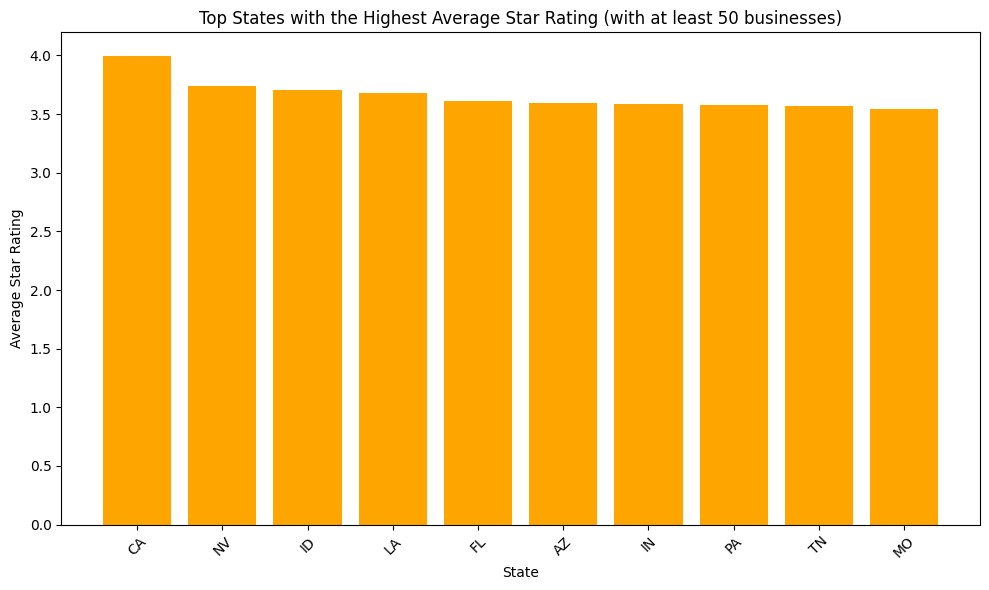

In [ ]:
import matplotlib.pyplot as plt

# Define the color for the bar plot (shade of orange)
bar_color = '#FFA500'  # Hex code for orange

# Convert the result DataFrame to Pandas for plotting
state_avg_stars_pd = state_avg_stars.limit(10).toPandas()

# Plot the top states with the highest average star rating
plt.figure(figsize=(10, 6))
plt.bar(state_avg_stars_pd['state'], state_avg_stars_pd['avg_stars'], color=bar_color)
plt.xlabel('State')
plt.ylabel('Average Star Rating')
plt.title('Top States with the Highest Average Star Rating (with at least 50 businesses)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


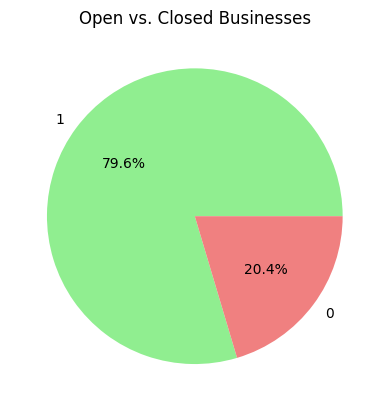

In [ ]:
open_closed_counts = df_pd['is_open'].value_counts()
open_closed_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Open vs. Closed Businesses')
plt.ylabel('')
plt.show()

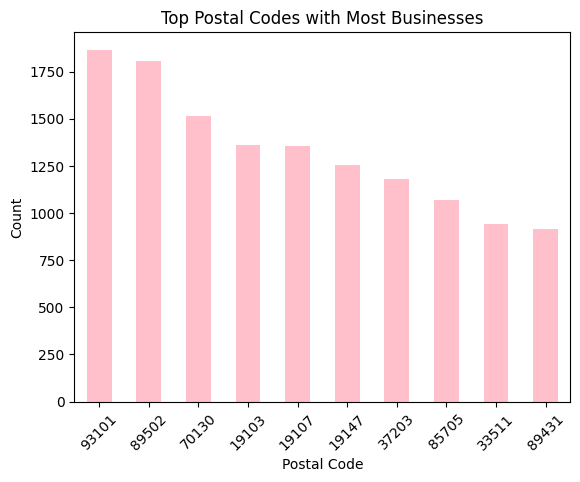

In [ ]:
postal_code_counts = df_pd['postal_code'].value_counts().nlargest(10)
postal_code_counts.plot(kind='bar', color='pink')
plt.xlabel('Postal Code')
plt.ylabel('Count')
plt.title('Top Postal Codes with Most Businesses')
plt.xticks(rotation=45)
plt.show()

In [ ]:
!pip install folium


In [ ]:
import folium
from folium.plugins import HeatMap

# Convert PySpark DataFrame to Pandas DataFrame
df_pd = df.select('latitude', 'longitude').toPandas()

# Create a base map centered at the mean of latitude and longitude
base_map = folium.Map(location=[df_pd['latitude'].mean(), df_pd['longitude'].mean()], zoom_start=10)

# Convert latitude and longitude to list of lists
heat_data = [[row['latitude'], row['longitude']] for index, row in df_pd.iterrows()]

# Plot heatmap
HeatMap(heat_data).add_to(base_map)

# Display the map
base_map


In [ ]:
# Show the hours column value for the first row
df.select('hours').show(3, truncate=False)


+----------------------------------------------------------------------+
|hours                                                                 |
+----------------------------------------------------------------------+
|NULL                                                                  |
|{8:0-18:30, 0:0-0:0, 8:0-14:0, NULL, 8:0-18:30, 8:0-18:30, 8:0-18:30} |
|{8:0-23:0, 8:0-22:0, 8:0-23:0, 8:0-22:0, 8:0-22:0, 8:0-22:0, 8:0-22:0}|
+----------------------------------------------------------------------+
only showing top 3 rows



In [ ]:
from pyspark.sql.functions import avg, count

# Group by category and calculate the average star rating and count
category_avg_count_stars = df.groupBy('categories').agg(avg('stars').alias('avg_stars'), count('business_id').alias('count')).orderBy('avg_stars', ascending=False)

# Group by city and calculate the average star rating and count
city_avg_count_stars = df.groupBy('city').agg(avg('stars').alias('avg_stars'), count('business_id').alias('count')).orderBy('avg_stars', ascending=False)

# Group by state and calculate the average star rating and count
state_avg_count_stars = df.groupBy('state').agg(avg('stars').alias('avg_stars'), count('business_id').alias('count')).orderBy('avg_stars', ascending=False)

# Show the top categories with the highest average star rating and count
print("Top categories with the highest average star rating and count:")
category_avg_count_stars.show(10)

# Show the top cities with the highest average star rating and count
print("Top cities with the highest average star rating and count:")
city_avg_count_stars.show(10)

# Show the top states with the highest average star rating and count
print("Top states with the highest average star rating and count:")
state_avg_count_stars.show(10)


Top categories with the highest average star rating and count:
+--------------------+---------+-----+
|          categories|avg_stars|count|
+--------------------+---------+-----+
|Pets, Pet Service...|      5.0|    1|
|Event Planning & ...|      5.0|    1|
|Cabinetry, Contra...|      5.0|    1|
|Fences & Gates, P...|      5.0|    1|
|Greek, Restaurant...|      5.0|    1|
|Caribbean, Empana...|      5.0|    1|
|Wedding Planning,...|      5.0|    1|
|Dog Walkers, Pet ...|      5.0|    1|
|Shopping, Eyewear...|      5.0|    1|
|Beauty & Spas, Re...|      5.0|    1|
+--------------------+---------+-----+
only showing top 10 rows

Top cities with the highest average star rating and count:
+----------------+---------+-----+
|            city|avg_stars|count|
+----------------+---------+-----+
|          Eagle,|      5.0|    1|
|        MERIDIAN|      5.0|    1|
|         Lutz fl|      5.0|    1|
|   Picture Rocks|      5.0|    1|
|      Ellisville|      5.0|    1|
|       Covington|      5.

In [ ]:
from pyspark.sql.functions import avg

# Filter businesses with at least 50 reviews
filtered_df = df.filter(df['review_count'] >= 50)

# Group by category and calculate the average star rating and total review count
category_avg_review_count_stars = filtered_df.groupBy('categories').agg(avg('stars').alias('avg_stars'), avg('review_count').alias('avg_review_count')).orderBy('avg_stars', ascending=False)

# Group by city and calculate the average star rating and total review count
city_avg_review_count_stars = filtered_df.groupBy('city').agg(avg('stars').alias('avg_stars'), avg('review_count').alias('avg_review_count')).orderBy('avg_stars', ascending=False)

# Group by state and calculate the average star rating and total review count
state_avg_review_count_stars = filtered_df.groupBy('state').agg(avg('stars').alias('avg_stars'), avg('review_count').alias('avg_review_count')).orderBy('avg_stars', ascending=False)

# Show the top categories with the highest average star rating and total review count
print("Top categories with the highest average star rating and total review count (with at least 50 reviews):")
category_avg_review_count_stars.show(10)

# Show the top cities with the highest average star rating and total review count
print("Top cities with the highest average star rating and total review count (with at least 50 reviews):")
city_avg_review_count_stars.show(10)

# Show the top states with the highest average star rating and total review count
print("Top states with the highest average star rating and total review count (with at least 50 reviews):")
state_avg_review_count_stars.show(10)


Top categories with the highest average star rating and total review count (with at least 50 reviews):
+--------------------+---------+----------------+
|          categories|avg_stars|avg_review_count|
+--------------------+---------+----------------+
|Home Services, La...|      5.0|            55.0|
|Restaurants, Deli...|      5.0|            89.0|
|Plumbing, Home Se...|      5.0|            75.0|
|French, Restauran...|      5.0|            57.0|
|Home Services, El...|      5.0|            57.0|
|Food, Turkish, Re...|      5.0|           128.0|
|Restaurants, Bage...|      5.0|            53.0|
|Sport Equipment H...|      5.0|            65.0|
|Nicaraguan, Carib...|      5.0|           152.0|
|Seafood, Restaura...|      5.0|           124.0|
+--------------------+---------+----------------+
only showing top 10 rows

Top cities with the highest average star rating and total review count (with at least 50 reviews):
+----------------+---------+----------------+
|            city|avg_star

In [ ]:
from pyspark.sql.functions import avg

# Filter businesses with at least 50 reviews
filtered_df = df.filter(df['review_count'] >= 50)

# Group by category and calculate the average star rating and total review count
category_avg_review_count_stars = filtered_df.groupBy('categories').agg(avg('stars').alias('avg_stars'), avg('review_count').alias('avg_review_count')).orderBy('avg_stars', ascending=False).limit(10).collect()

# Group by city and calculate the average star rating and total review count
city_avg_review_count_stars = filtered_df.groupBy('city').agg(avg('stars').alias('avg_stars'), avg('review_count').alias('avg_review_count')).orderBy('avg_stars', ascending=False).limit(10).collect()

# Group by state and calculate the average star rating and total review count
state_avg_review_count_stars = filtered_df.groupBy('state').agg(avg('stars').alias('avg_stars'), avg('review_count').alias('avg_review_count')).orderBy('avg_stars', ascending=False).limit(10).collect()

# Display the top categories with the highest average star rating and total review count
print("Top categories with the highest average star rating and total review count (with at least 50 reviews):")
for row in category_avg_review_count_stars:
    print(row)

# Display the top cities with the highest average star rating and total review count
print("Top cities with the highest average star rating and total review count (with at least 50 reviews):")
for row in city_avg_review_count_stars:
    print(row)

# Display the top states with the highest average star rating and total review count
print("Top states with the highest average star rating and total review count (with at least 50 reviews):")
for row in state_avg_review_count_stars:
    print(row)


Top categories with the highest average star rating and total review count (with at least 50 reviews):
Row(categories='Home Services, Landscaping, Tree Services, Gardeners', avg_stars=5.0, avg_review_count=55.0)
Row(categories='Cosmetics & Beauty Supply, Reiki, Skin Care, Eyelash Service, Health & Medical, Massage, Shopping, Hair Removal, Beauty & Spas, Massage Therapy, Day Spas, Waxing', avg_stars=5.0, avg_review_count=161.0)
Row(categories='Plumbing, Home Services, Water Heater Installation/Repair', avg_stars=5.0, avg_review_count=75.0)
Row(categories='Restaurants, Bagels, Donuts, Food, Breakfast & Brunch', avg_stars=5.0, avg_review_count=53.0)
Row(categories='Home Services, Electricians, Lighting Fixtures & Equipment', avg_stars=5.0, avg_review_count=57.0)
Row(categories='Seafood, Restaurants, Hawaiian, Poke, Food', avg_stars=5.0, avg_review_count=124.0)
Row(categories='Food, Turkish, Restaurants, Coffee & Tea, Bakeries', avg_stars=5.0, avg_review_count=128.0)
Row(categories='French

In [ ]:
from pyspark.sql.functions import avg

# Filter DataFrame for businesses with "is_open" as false and calculate average rating
closed_avg_rating = df.filter(df['is_open'] == False).select(avg('stars')).first()[0]

# Filter DataFrame for businesses with "is_open" as true and calculate average rating
open_avg_rating = df.filter(df['is_open'] == True).select(avg('stars')).first()[0]

print("Average rating for closed businesses:", closed_avg_rating)
print("Average rating for open businesses:", open_avg_rating)


Average rating for closed businesses: 3.56415990409443
Average rating for open businesses: 3.663200325369941


In [ ]:
from pyspark.sql.functions import avg, count

# Group by 'is_open' column and calculate count, average star rating, and average review count
open_closed_stats = df.groupBy('is_open').agg(
    count('business_id').alias('business_count'),
    avg('stars').alias('avg_stars'),
    avg('review_count').alias('avg_review_count')
)

# Show the statistics
open_closed_stats.show()


+-------+--------------+-----------------+-----------------+
|is_open|business_count|        avg_stars| avg_review_count|
+-------+--------------+-----------------+-----------------+
|      0|        130128| 3.56415990409443|44.04686155170294|
|      1|        538464|3.663200325369941|54.63192153978725|
+-------+--------------+-----------------+-----------------+



In [ ]:
open_closed_stats_pd = open_closed_stats.toPandas()


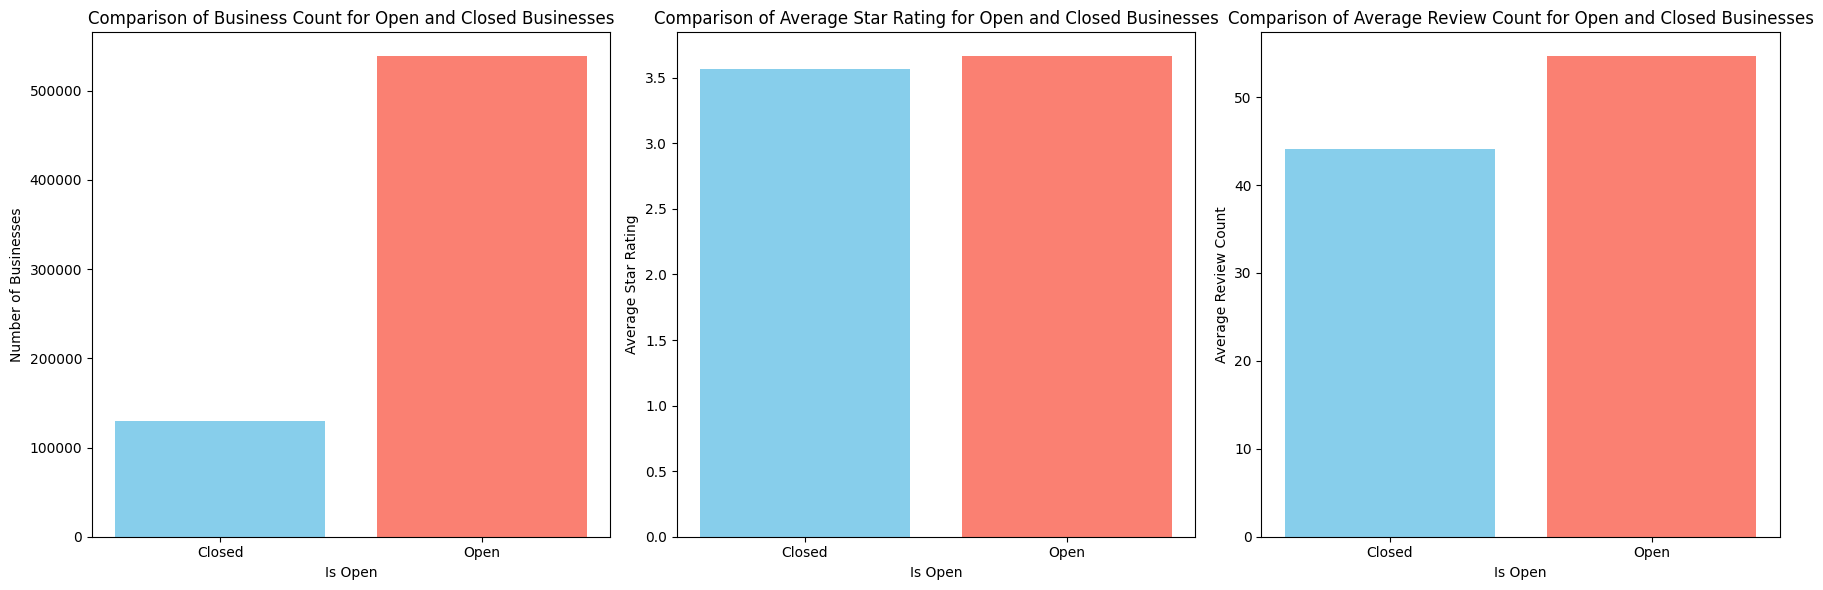

In [ ]:
# Create a figure with 1 row and 3 columns
plt.figure(figsize=(18, 6))

# Plot 1: Business Count
plt.subplot(1, 3, 1)
plt.bar(['Closed', 'Open'], open_closed_stats_pd['business_count'], color=['skyblue', 'salmon'])
plt.xlabel('Is Open')
plt.ylabel('Number of Businesses')
plt.title('Comparison of Business Count for Open and Closed Businesses')

# Plot 2: Average Star Rating
plt.subplot(1, 3, 2)
plt.bar(['Closed', 'Open'], open_closed_stats_pd['avg_stars'], color=['skyblue', 'salmon'])
plt.xlabel('Is Open')
plt.ylabel('Average Star Rating')
plt.title('Comparison of Average Star Rating for Open and Closed Businesses')

# Plot 3: Average Review Count
plt.subplot(1, 3, 3)
plt.bar(['Closed', 'Open'], open_closed_stats_pd['avg_review_count'], color=['skyblue', 'salmon'])
plt.xlabel('Is Open')
plt.ylabel('Average Review Count')
plt.title('Comparison of Average Review Count for Open and Closed Businesses')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
df_pd = df.toPandas()
# Frequency of Attribute Values using Pandas DataFrame
attribute_value_counts_pd = df_pd['attributes'].apply(pd.Series).stack().value_counts()
print(attribute_value_counts_pd)


True                                                                                                                                                                 2485266
False                                                                                                                                                                1185958
2                                                                                                                                                                     234502
{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}                                                                                   167441
u'free'                                                                                                                                                               141061
                                                                                                                                       